In [49]:
import time
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
import numpy as np
import pickle
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, LeaveOneGroupOut,TimeSeriesSplit,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from scipy import interp
from statsmodels.stats.proportion import proportions_ztest as zt
from statsmodels.stats.contingency_tables import mcnemar
from abroca import *
pd.set_option('display.max_columns', None)

In [50]:
DATA = pd.read_csv('~/projects/panel/features_engineering/ALL_SCHOOLS_v2.csv')
geodata = pd.read_csv("~/data/geodata/estados.csv")

In [51]:
DATA = pd.merge(DATA, geodata, left_on= 'CO_UF',right_on= 'cod' ,how = 'inner')

In [52]:
#Only elementary infrastructure schools
#print(DF)
DATA= DATA.loc[(DATA.IN_AGUA_INEXISTENTE == 0) & (DATA.IN_ENERGIA_INEXISTENTE == 0) & (DATA.IN_ESGOTO_INEXISTENTE == 0)]

In [53]:
QT_to_IN = ['QT_EQUIP_DVD', 'QT_EQUIP_COPIADORA', 'QT_EQUIP_IMPRESSORA', 'QT_EQUIP_TV']
conds = [DATA[QT_to_IN].values == 0 , DATA[QT_to_IN].values > 0]
choices = [0, 1]
DATA[QT_to_IN] = pd.DataFrame(np.select(conds, choices), index=DATA[QT_to_IN].index, columns=DATA[QT_to_IN].columns)
#DF[QT_to_IN] = DF[QT_to_IN].astype('category')

In [54]:
gp =DATA.loc[DATA.CO_ANO==2019].groupby("uf")[non_actionable].mean().sort_values(by=["TP_SEXO"])
gp.reset_index()

,uf,TP_COR_RACA_1.0,TP_SEXO,TP_COR_RACA_2.0,TP_COR_RACA_3.0,TP_COR_RACA_4.0,TP_COR_RACA_5.0
0,Bahia,0.174645,0.390911,0.252485,0.505780,0.027931,0.008491
1,Minas Gerais,0.405398,0.391071,0.117651,0.436276,0.020472,0.004007
2,Rondônia,0.274693,0.391574,0.099446,0.569648,0.027786,0.005658
3,Rio Grande do Sul,0.805805,0.396672,0.044442,0.122307,0.004850,0.001607
4,Santa Catarina,0.789652,0.399943,0.026643,0.151689,0.008754,0.002055
5,Roraima,0.182617,0.405060,0.068865,0.669098,0.014731,0.049419
6,Mato Grosso do Sul,0.455145,0.409232,0.062469,0.415447,0.022764,0.023429
7,Rio de Janeiro,0.468982,0.411442,0.154642,0.338547,0.016274,0.002990
8,Goiás,0.326349,0.413356,0.103675,0.494804,0.041371,0.005828
9,Maranhão,0.174497,0.415227,0.132628,0.652469,0.015699,0.004072


In [55]:
DATA.shape

(219321, 82)

In [56]:
DATA.columns

Index(['Unnamed: 0', 'CO_ANO', 'CO_ESCOLA', 'NU_IDADE', 'TP_SEXO',
       'TP_ST_CONCLUSAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
       'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'EDU_PAI', 'EDU_MAE',
       'QT_PESSOAS_CASA', 'RENDA_MENSAL', 'NU_NOTA_GERAL', 'CO_MUNICIPIO',
       'CO_UF', 'CO_DEPENDENCIA_ADM', 'IN_AGUA_INEXISTENTE',
       'IN_ESGOTO_INEXISTENTE', 'IN_ENERGIA_INEXISTENTE',
       'IN_LABORATORIO_INFORMATICA', 'IN_LABORATORIO_CIENCIAS',
       'IN_SALA_ATENDIMENTO_ESPECIAL', 'IN_BIBLIOTECA', 'IN_SALA_LEITURA',
       'IN_BANHEIRO', 'IN_BANHEIRO_PNE', 'QT_SALAS_UTILIZADAS', 'QT_EQUIP_TV',
       'QT_EQUIP_DVD', 'QT_EQUIP_COPIADORA', 'QT_EQUIP_IMPRESSORA',
       'QT_COMP_ALUNO', 'IN_INTERNET', 'IN_BANDA_LARGA', 'QT_FUNCIONARIOS',
       'IN_ALIMENTACAO', 'IN_COMUM_MEDIO_MEDIO', 'IN_COMUM_MEDIO_INTEGRADO',
       'IN_COMUM_MEDIO_NORMAL', 'IN_SALA_PROFESSOR', 'IN_QUADRA_ESPORTES',
       'IN_COZINHA', 'IN_EQUIP_PARABOLICA', 'IN_ATIV_COMPLEMENTAR',
       'QT_MATRICULAS', 'TI

In [57]:
controls = ["CO_ANO", 'IN_TP_ESCOLA','codigo_uf', 'regiao']
school = [

                          'IN_LABORATORIO_CIENCIAS',
                          'IN_SALA_ATENDIMENTO_ESPECIAL',
                          'IN_BIBLIOTECA',
                          'IN_SALA_LEITURA',
                          'IN_BANHEIRO',
                          'IN_BANHEIRO_PNE',
                          'QT_SALAS_UTILIZADAS',
                          'QT_EQUIP_TV',
                          'QT_EQUIP_DVD',
                          'QT_EQUIP_COPIADORA',
                          'QT_EQUIP_IMPRESSORA',
                          'QT_COMP_ALUNO',
                          'IN_BANDA_LARGA',
                          'QT_FUNCIONARIOS',
                          'IN_ALIMENTACAO',
                          'IN_SALA_PROFESSOR',
                          'IN_COZINHA',
                          'IN_EQUIP_PARABOLICA',
                          'IN_QUADRA_ESPORTES',
                          'IN_ATIV_COMPLEMENTAR',
                          'QT_MATRICULAS',
                          'IN_COMUM_MEDIO_INTEGRADO'  
                          
                         ]

teacher = ['TITULACAO', 'IN_FORM_DOCENTE','NU_LICENCIADOS', 
              'NU_CIENCIA_NATUREZA','NU_CIENCIAS_HUMANAS', 'NU_LINGUAGENS_CODIGOS', 'NU_MATEMATICA',  'NU_ESCOLAS', 
           'DIVERSIDADE']

student =['RENDA_PERCAPITA','EDU_PAI', 'EDU_MAE','NU_IDADE']

non_actionable = ['TP_COR_RACA_1.0','TP_SEXO',
                        'TP_COR_RACA_2.0', 'TP_COR_RACA_3.0', 'TP_COR_RACA_4.0',
                        'TP_COR_RACA_5.0']

target = ['NU_NOTA_GERAL']

nordeste = ["BA", "SE", "AL", "PE", "PB", "RN", "CE", "MA", "PI"]
sudeste = ["SP", "MG", "ES", "RJ"]
sul = ["RS", "PR", "SC"]
norte = ["AM", "RR", "RO", "AP", "PA", "TO", "AC"]
centroeste = ["DF", "MS", "MT", "GO"]


In [58]:
print('school',len(school))
print('teacher',len(teacher))
print('student',len(student))
print('non_actionable',len(non_actionable))
independents = school + teacher + student + non_actionable
DATA = DATA[controls + independents +  target]

school 22
teacher 9
student 4
non_actionable 6


In [59]:
DATA.head()


,CO_ANO,IN_TP_ESCOLA,codigo_uf,regiao,IN_LABORATORIO_CIENCIAS,IN_SALA_ATENDIMENTO_ESPECIAL,IN_BIBLIOTECA,IN_SALA_LEITURA,IN_BANHEIRO,IN_BANHEIRO_PNE,QT_SALAS_UTILIZADAS,QT_EQUIP_TV,QT_EQUIP_DVD,QT_EQUIP_COPIADORA,QT_EQUIP_IMPRESSORA,QT_COMP_ALUNO,IN_BANDA_LARGA,QT_FUNCIONARIOS,IN_ALIMENTACAO,IN_SALA_PROFESSOR,IN_COZINHA,IN_EQUIP_PARABOLICA,IN_QUADRA_ESPORTES,IN_ATIV_COMPLEMENTAR,QT_MATRICULAS,IN_COMUM_MEDIO_INTEGRADO,TITULACAO,IN_FORM_DOCENTE,NU_LICENCIADOS,NU_CIENCIA_NATUREZA,NU_CIENCIAS_HUMANAS,NU_LINGUAGENS_CODIGOS,NU_MATEMATICA,NU_ESCOLAS,DIVERSIDADE,RENDA_PERCAPITA,EDU_PAI,EDU_MAE,NU_IDADE,TP_COR_RACA_1.0,TP_SEXO,TP_COR_RACA_2.0,TP_COR_RACA_3.0,TP_COR_RACA_4.0,TP_COR_RACA_5.0,NU_NOTA_GERAL
0,2009,Municipal+Estadual,RJ,Sudeste,0.0,0.0,1.0,0.0,1.0,0.0,16.0,1,1,1,1,10.0,1.0,110.0,1.0,1.0,1.0,1.0,1.0,0.0,35.666667,0.0,0.074074,0.780303,0.979167,0.145833,0.229167,0.437500,0.187500,1.291667,1.000000,540.115079,1.285714,1.571429,18.380952,0.142857,0.333333,0.047619,0.523810,0.000000,0.047619,487.262857
1,2009,Municipal+Estadual,RJ,Sudeste,0.0,0.0,1.0,0.0,1.0,1.0,10.0,1,1,1,1,10.0,1.0,128.0,1.0,1.0,1.0,0.0,1.0,0.0,32.857143,0.0,0.187500,0.862121,1.000000,0.222222,0.277778,0.361111,0.138889,1.472222,0.972222,893.519864,1.639535,2.279070,18.406977,0.360465,0.383721,0.081395,0.488372,0.023256,0.000000,526.395581
2,2009,Privada,RJ,Sudeste,0.0,0.0,1.0,0.0,1.0,0.0,8.0,1,1,1,1,4.0,1.0,36.0,0.0,1.0,0.0,0.0,0.0,0.0,26.000000,0.0,0.071429,0.840909,1.000000,0.285714,0.285714,0.357143,0.071429,1.928571,0.928571,3000.112500,1.450000,1.750000,18.300000,0.300000,0.450000,0.000000,0.250000,0.000000,0.100000,543.619000
3,2009,Privada,RJ,Sudeste,1.0,0.0,1.0,0.0,1.0,0.0,16.0,1,1,0,1,24.0,1.0,56.0,0.0,1.0,0.0,0.0,1.0,0.0,64.750000,0.0,0.053030,0.924242,1.000000,0.166667,0.285714,0.404762,0.142857,2.857143,0.976190,3683.656994,3.812500,3.825893,18.214286,0.794643,0.459821,0.017857,0.120536,0.004464,0.000000,663.769464
4,2009,Privada,RJ,Sudeste,1.0,0.0,1.0,0.0,1.0,0.0,28.0,1,1,1,1,15.0,1.0,95.0,0.0,1.0,0.0,0.0,1.0,0.0,53.000000,0.0,0.127273,0.866721,0.954545,0.211538,0.269231,0.326923,0.192308,1.960000,0.846154,3409.651667,3.200000,3.120000,18.280000,0.700000,0.400000,0.020000,0.080000,0.040000,0.000000,657.158400


Functions that will be called in Model

In [60]:
## Dropping hight mode frequencies (upper 90%)
def mode_high_frequencie(df):
    columns_dropped = []
    ammount=0
    before= df.shape[1]
    #print("Number of features: ", before)
    for i in df:
        mode = df[i].mode()[0]
        threshold = 0.9
        count = df[(df[i]== mode)].shape[0]
        freq = count/df.shape[0]
        if freq >= threshold:
            ammount +=1
            #print("drop out", [i], "mode = ", mode )
            #df.drop([i], inplace = True, axis=1)
            columns_dropped.append(i)
            
    #print("Total Dropped: ",ammount)
    #print ("Remainning: ", before-ammount)  
    return(columns_dropped)

In [61]:
def clip_tail(df):
    quantitative = df[(df.nunique() > 2).index[(df.nunique() > 2)]].columns.to_list()
    #print(len(quantitative)
    df[quantitative]=df[quantitative].apply(lambda x: x.clip(upper = (np.percentile(x, 97.5))))
    df[quantitative]=df[quantitative].apply(lambda x: x.clip(lower = (np.percentile(x, 2.5))))
    return(df)

In [62]:
def scaler (df):
    scaler = MinMaxScaler()
    x = df.values
    x_scaled = scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled, columns = df.columns)
    return (df)

In [63]:
def build_target(df):
    df['TARGET'] = pd.qcut (df.NU_NOTA_GERAL, 4, labels = [1,2,3,4]).map(lambda x : 0 if x<3 else 1) 
    #rint((df.TARGET==0).sum()/(df.TARGET.count())*100, '% lowers quartis')
    return df['TARGET']

In [64]:
def abroca(df, group_ref, baseline):
    #print(group_ref)
    pred_res =pd.DataFrame([], columns= [political_unit, 'abroca'])

    for i in df[group_ref].unique():
        if i != baseline:
            #print(i, 'aqui', baseline)
            temp= df[['y_proba' , 'y_true', political_unit]]
            temp = temp[(temp[group_ref]== baseline) | (temp[group_ref]==i)]
        #temp = pd.get_dummies(temp)
            temp[political_unit] = LabelEncoder().fit_transform(temp[political_unit])
        #print(temp.head())
            prot_attr = temp.iloc[:,2].name
        #print(prot_attr)
        #temp.iloc[:,2] =temp.iloc[:,2].astype('str')
       
            abroca_score = compute_abroca(temp, pred_col = 'y_proba' , label_col = 'y_true', n_grid = 10000,
                                majority_protected_attr_val = 1,compare_type='binary',protected_attr_col = prot_attr, plot_slices =False)
        #print(abroca_score)
    
            res = pd.DataFrame({political_unit: [i], 'abroca': list(abroca_score.values())})
            pred_res = pred_res.append(res)
    return(pred_res)
                           
        
    
      

In [65]:
def compute_scores (pred_res, political_unit, ref):
    groups = [political_unit] + ['model']
    #.groupby(groups).apply(lambda x: abroca(x, political_unit, ref))
    #print(pred_res)
    #pred_res['auc_general'] = pred_res.groupby('model').apply(lambda x: roc_auc_score(x.y_true, x.y_proba))
    #print(pred_res['auc_general'])
    #pred_res['f1_general'] = pred_res.groupby('model').apply(lambda x: f1_score(x.y_true.to_list(), x.y_pred.to_list()))
    #print(temp)
    
    #print (groups)
    pred_eval_score_general = pred_res.groupby('model').apply(lambda x: pd.DataFrame(
            {
                'auc_model': [roc_auc_score(x.y_true, x.y_proba)],
                'f1_model': f1_score(x.y_true.to_list(), x.y_pred.to_list())
            }
            )).droplevel(1).apply(pd.to_numeric)  
    
    pred_eval_score = pred_res.groupby(groups).apply(lambda x: pd.DataFrame(
            {
                'tp': [len(x.query('y_true == 1 and y_pred == 1'))],
                'tn': [len(x.query('y_true == 0 and y_pred == 0'))],
                'fp': [len(x.query('y_true == 0 and y_pred == 1'))],
                'fn': [len(x.query('y_true == 1 and y_pred == 0'))],
                'auc':(roc_auc_score(x.y_true, x.y_proba) if len(np.unique(x.y_true)) != 1 else 0) 
               
            
            }
            )).droplevel(2).apply(pd.to_numeric)
    #print('first',pred_eval_score.head())

    pred_eval_score = pred_eval_score.assign(f1=lambda x: 2*x['tp']/(2*x['tp']+x['fp']+x['fn']))      
    pred_eval_score = pred_eval_score.assign(acc=lambda x: (x['tp']+x['tn'])/(x['tp']+x['tn']+x['fp']+x['fn']))
    pred_eval_score = pred_eval_score.assign(fnr=lambda x: x['fn']/(x['fn']+x['tp']))
    pred_eval_score = pred_eval_score.assign(fpr=lambda x: x['fp']/(x['fp']+x['tn']))
    #pred_eval_score = pred_eval_score.assign(auc=auc)
    pred_eval_score = pred_eval_score.reset_index()
    #print('primeiro',pred_eval_score.head())
    #print('segundo',pred_eval_score_general.head())
    pred_eval_score = pd.merge(pred_eval_score, pred_eval_score_general, on ='model', how='left')
    #print('final',pred_eval_score.head())
    return (pred_eval_score)

In [66]:
def run_models(data, group_ref, m, tp_school):

    global student
    global school
    global teacher
    global non_actionable
    groups ={}
    scores = {}
    data = data[data.IN_TP_ESCOLA == tp_school] # Filter only target type school
    group_var = [group_ref]
    logo = LeaveOneGroupOut()
    for year in data.CO_ANO.unique():
        data_y = data[data.CO_ANO==year]
        y = build_target(data_y).to_numpy()
        df= data_y[independents + group_var] #Get all features set 
        bad_columns = mode_high_frequencie(df[independents])
    # update each group list, removing them
        full = df[independents].loc[:, ~df[independents].columns.isin(bad_columns)].columns.to_list()  
        student = df[student].loc[:, ~df[student].columns.isin(bad_columns)].columns.to_list()
        school = df[school].loc[:, ~df[school].columns.isin(bad_columns)].columns.to_list()   
        teacher = df[teacher].loc[:, ~df[teacher].columns.isin(bad_columns)].columns.to_list()   
        non_actionable = df[non_actionable].loc[:, ~df[non_actionable].columns.isin(bad_columns)].columns.to_list()
        
    # create dictionry with all combinations of features    
        groups['FULL'] = df[full]
    #single variable
        groups['SCHOOL'] = df[school]
        groups['STUDENT'] = df[student]
        groups['TEACHER'] = df[teacher]
        groups['NON_ACTIONABLE'] = df[non_actionable]
    
    #two variables
        groups['SCHOOL_STUDENT'] = df[school + student]
        groups['SCHOOL_TEACHER'] = df[school + teacher ]
        groups['SCHOOL_NON_ACTIONABLE'] = df[school + non_actionable]
        groups['STUDENT_TEACHER'] = df[student+ teacher]
        groups['STUDENT_NON_ACTIONABLE'] = df[student + non_actionable]
        groups['TEACHER_NON_ACTIONABLE'] = df[teacher + non_actionable]
    #Three variables
        groups['SCHOOL_STUDENT_TEACHER'] = df[school + student + teacher]
        groups['SCHOOL_STUDENT_NON_ACTIONABLE'] = df[school + student + non_actionable]
        groups['SCHOOL_TEACHER_NON_ACTIONABLE'] = df[school + teacher+ non_actionable]
        groups['STUDENT_TEACHER_NON_ACTIONABLE'] = df[student + teacher + non_actionable]
        
        df = df.set_index(group_ref) 
        unique_id = df.index.to_frame().reset_index(drop=True)
        
        scores[year]= {}
        for gp in groups:
            pred_res = pd.DataFrame([], columns=unique_id.columns.tolist()+['y_true', 'y_pred', 'y_proba', 'model'])  
            scores[year][gp]= {}
            X = groups[gp].to_numpy()
            group = df.index.get_level_values(group_ref)
            #print(group)
            for m in models:
                name_classifier = type(m).__name__
                #print(name_classifier)
                ypred = cross_val_predict(m, X, y, cv=logo,groups=group)
                yproba = cross_val_predict(m, X, y, cv=logo,groups=group, method='predict_proba')[:,1]
            
                #ypred = cross_val_predict(m, X, y, cv=10)
                #yproba = cross_val_predict(m, X, y, cv=10,method='predict_proba')[:,1]
  
                res = pd.DataFrame({'y_true': y, 'y_pred': ypred, 'y_proba': yproba, 'model': name_classifier})
                pred_res = pred_res.append(pd.concat([unique_id, res], axis=1))
                pred_res['y_true'] = pred_res['y_true'].astype(int)
                #print(pred_res.head())
            
    
                scores[year][gp] = compute_scores(pred_res, political_unit, ref)
         
    
    return(scores,pred_res)
    

In [67]:
#DATA_TESTE = DATA[DATA.IN_TP_ESCOLA =='Municipal+Estadual']

In [ ]:
rseed = 1234
models = [LogisticRegression(),  RandomForestClassifier(random_state=0), AdaBoostClassifier(random_state=0)]
political_unit = 'regiao'
ref = 'PR'
tp_level = "Municipal+Estadual"
big_table, raw_pred = run_models(DATA, political_unit, models, tp_level)
     

In [185]:
raw_pred['decile']=pd.qcut (raw_pred.y_proba, 10, labels = [1,2,3,4,5,6,7,8,9,10]).astype('category')

In [76]:
roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) != 1 else 1333

1.0

In [74]:
y_true =[0,0,0,0,0,0,0,0,0,0,0,0,0,1]
y_proba =[0,0,0,0,0,0,0,0,0,0,0,0,0,1]

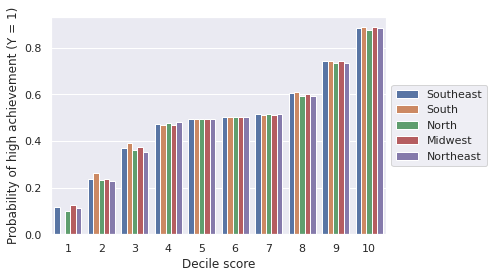

In [188]:
import seaborn as sns
sns.set(color_codes=True)
sns.color_palette("Paired")
g =sns.barplot(x="decile", y="y_proba", hue="regiao", data=raw_pred, ci=None)
g.set(xlabel="Decile score",
      ylabel="Probability of high achievement (Y = 1)");

g.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=["Southeast", "South", "North", "Midwest", "Northeast"])

#g.legend()

In [46]:
#with open('file_state.pkl', 'wb') as f:
#    pickle.dump(big_table, f)

In [26]:
with open('file_state.pkl', 'rb') as f:
    big_table = pickle.load(f) 

In [27]:
big_table[i]['FULL']

KeyError: 0

In [28]:
temp = pd.DataFrame()
dfin=pd.DataFrame()
for i in big_table.keys():
    #print (i) 
    if (i ==2009):
        dfin = big_table[i]['FULL'].groupby('codigo_uf').apply(lambda x: x.loc[x.f1_model == x.f1_model.max()]).droplevel(0)[['codigo_uf','auc_model']]
        dfin.reset_index(drop=True, inplace=True)
    else:
        temp = big_table[i]['FULL'].groupby('codigo_uf').apply(lambda x: x.loc[x.f1_model == x.f1_model.max()]).droplevel(0)[['auc_model']]
        temp.reset_index(drop=True, inplace=True)
        dfin =pd.concat([dfin, temp], axis=1, ignore_index=True)

In [29]:
print(dfin.mean(axis=0).to_frame().T.round(2))
print(dfin.std(axis=0).to_frame().T.round(2))

     1    2    3     4     5     6     7     8    9     10   11
0  0.74  0.8  0.8  0.82  0.82  0.82  0.82  0.81  0.8  0.81  0.8
    1    2    3    4    5    6    7    8    9    10   11
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [30]:
def df_proportion_class (DF, tp_escola, level):
        level = 'codigo_uf' if level == 'estado' else 'regiao'
        df, df2 = pd.DataFrame(), pd.DataFrame()
        mun_est = DF[(DF.IN_TP_ESCOLA == tp_escola)]
    
        for i in mun_est.CO_ANO.unique():  
            mun_est_y = mun_est[mun_est['CO_ANO']==i]
            mun_est_y['target']= build_target(mun_est_y).to_numpy()
            grp = mun_est_y[['CO_ANO',level, 'target']].groupby([level])
            df[i] = grp.apply (lambda x: x.target.sum()/x.target.count())
            df2[i] = mun_est_y[['CO_ANO',level, 'NU_NOTA_GERAL']].groupby([level])['NU_NOTA_GERAL'].mean()
        return df, df2

In [31]:
def build_df (level, metric, big_table, year):
    level = 'codigo_uf' if level == 'estado' else 'regiao'
    df = pd.DataFrame()
    for k, v in big_table.items():
        #print(k)
        if (k == year):
            for nk, nv in v.items(): 
                #print(nk)
                nv = nv.groupby(level).apply(lambda x: x.loc[x.f1_model == x.f1_model.max()]).droplevel(0)
                for i in range (nv.shape[0]):
                #print(i)
                #nv = nv.groupby('regiao')['auc'].max()
                    column = nv.reset_index()[level][i]
                    value = nv[[level,metric]].iloc[i][1]
                    model = nv.reset_index().model[i]
                    f1_model = nv.reset_index().f1_model[i]
                    auc_model = nv.reset_index().auc_model[i]
                    df.loc[nk, 'Model'] = model
                    df.loc[nk, 'F1_measure'] = f1_model
                    df.loc[nk, 'AUC'] = auc_model
                    df.loc[nk, column] = value
                
                #print(column, value)
                

    return (df.round(2))

In [32]:

dfin.loc[dfin.index.isin(list_units)]
temp = pd.DataFrame()
for i in big_table.keys():
    print (i) 
    if (i ==2009):
        dfin = build_df('estado', 'fnr',big_table, i).iloc[0,3:].to_frame()
    else:
        temp = build_df('estado', 'fnr',big_table, i).iloc[0,3:].to_frame()
        dfin =pd.concat([dfin, temp], axis=1)



2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [33]:
#
dfin.loc[dfin.index.isin(nordeste)].iloc[:, 10].sort_values(ascending=False)

SE    0.91
AL    0.89
PI    0.84
BA    0.84
PB    0.79
CE    0.75
RN    0.64
PE    0.56
MA     0.4
Name: FULL, dtype: object

In [34]:
top_10_notas = DATA[(DATA.IN_TP_ESCOLA == "Municipal+Estadual")].groupby(['codigo_uf'])['NU_NOTA_GERAL'].mean().sort_values(ascending=False).head(10).index

In [35]:
dfin.loc[dfin.index.isin(top_10_notas)].apply(lambda x: x.mean(), axis=1).sort_values(ascending=False)

MG    0.502727
RJ    0.340000
GO    0.322727
ES    0.305455
MS    0.198182
DF    0.191818
RS    0.072000
SP    0.070000
SC    0.057273
PR    0.042727
dtype: float64

In [36]:
top_10_notas

Index(['DF', 'RS', 'MG', 'SC', 'RJ', 'SP', 'PR', 'MS', 'ES', 'GO'], dtype='object', name='codigo_uf')

In [37]:
target = 'Nordeste'
refs = ['Centroeste', 'Norte', 'Sudeste', 'Sul']
a=big_table[2019]['STUDENT_NON_ACTIONABLE'] 
a= a.loc[a.model=="AdaBoostClassifier"]

for i in refs:
    
    fp_ref = a[a.regiao == target]['fn'] 
    fp = a[a.regiao.isin([i])]['fn']

    tn_ref= a[a.regiao == target]['tp']
    tn = a[a.regiao.isin([i])]['tp']

    count = [fp_ref , fp]
    nobs = [fp_ref + tn_ref, fp + tn]
#alternative = 'larger' if one_sided else 'two-sided'
    stat, pval = zt(count, nobs, alternative="larger")
    print('z-proportion test pvalue=%.4f' % (pval).round(3), 'for', target,'and', i)

AttributeError: 'DataFrame' object has no attribute 'regiao'

In [38]:
df = build_df('estado', 'fnr',big_table, 2009)
df[['BA', 'AL', 'SE', 'PE','CE','MA','RN','PI','PB']].loc['FULL'].sort_values()

RN    0.54
PE    0.73
MA    0.73
SE    0.76
PB    0.79
BA    0.80
CE    0.87
AL    0.89
PI    0.89
Name: FULL, dtype: float64

In [39]:
b =big_table[2019]['FULL']
b.loc[b.codigo_uf =="SE"]

,codigo_uf,model,tp,tn,fp,fn,f1,acc,fnr,fpr,auc_model,f1_model
72,SE,AdaBoostClassifier,8,83,2,49,0.238806,0.640845,0.859649,0.023529,0.799492,0.724958
73,SE,LogisticRegression,3,83,2,54,0.096774,0.605634,0.947368,0.023529,0.785446,0.708419
74,SE,RandomForestClassifier,5,84,1,52,0.158730,0.626761,0.912281,0.011765,0.797660,0.725091


In [40]:
a =big_table[2019]['SCHOOL'][['f1_model','tn', 'tp','fp','fn', 'fpr', 'fnr', 'model', 'codigo_uf']]
a.groupby('codigo_uf').apply(lambda x: x.loc[x.f1_model == x.f1_model.max()]).droplevel(0)
df[['BA','AL', 'SE', 'PE','PB','RN','CE','MA','PI']].round(2)[:1]

,BA,AL,SE,PE,PB,RN,CE,MA,PI
FULL,0.8,0.89,0.76,0.73,0.79,0.54,0.87,0.73,0.89


In [41]:
from matplotlib.collections import LineCollection
def crossout(points, ax=None, scale=1, **kwargs):
    ax = ax or plt.gca()
    l = np.array([[[1,1],[-1,-1]]])*scale/2.
    r = np.array([[[-1,1],[1,-1]]])*scale/2.
    p = np.atleast_3d(points).transpose(0,2,1)
    c = LineCollection(np.concatenate((l+p,r+p), axis=0), **kwargs)
    ax.add_collection(c)
    return c


def z_test (unit1, unit2, feature_set, metric, year, level, big_table):
    level = 'codigo_uf' if level == 'estado' else 'regiao'
    a = big_table[year][feature_set][['tn', 'tp','fp','fn', 'f1_model','model', level]]
    a = a.groupby(level).apply(lambda x: x.loc[x.f1_model == x.f1_model.max()]).droplevel(0)
    
    
    if metric == "fpr":
        c1 = a[a[level] == unit1]['fp'] 
        c2 = a[a[level] == unit2]['fp']
        o1 = a[a[level] == unit1]['tn']
        o2 = a[a[level] == unit2]['tn']
    elif metric == 'fnr':
        c1 = a[a[level] == unit1]['fn'] 
        c2 = a[a[level] == unit2]['fn']
        o1 = a[a[level] == unit1]['tp']
        o2 = a[a[level] == unit2]['tp']

    
    count = [c1 , c2]
    nobs = [c1 + o1, c2 + o2]
    #print(count)
    #print(nobs)

    stat, pval = zt(count, nobs, alternative="two-sided")
    return (pval)
    
def matrix (level, metric, big_table, year, feature_set, list_units):
    ratio = []
    significance = []
    df = build_df(level, metric, big_table, year)
    df = df.loc[[feature_set]]
    order_axis = df[list_units].loc[feature_set].sort_values(ascending = False).index
    for i in order_axis:
        #print(i)
        a = []
        b = []
        for j in order_axis:
            #print(j)
            axisy = df[i].iloc[0]
            #print (axisy)
            axisx = df[j].iloc[0]
            #print (axisx)
            value = (axisy/axisx).round(2)
           
            pvalue = (z_test(i, j, feature_set, metric, year, level, big_table)[0].round(3))
            #pvalue[0]
            #print("value=",value)
            #print("pvalue=",pvalue)
            a.append(value)
            b.append(pvalue)
        
        ratio.append(a)
        significance.append(b)
    return ratio, significance, order_axis

KeyError: 'regiao'

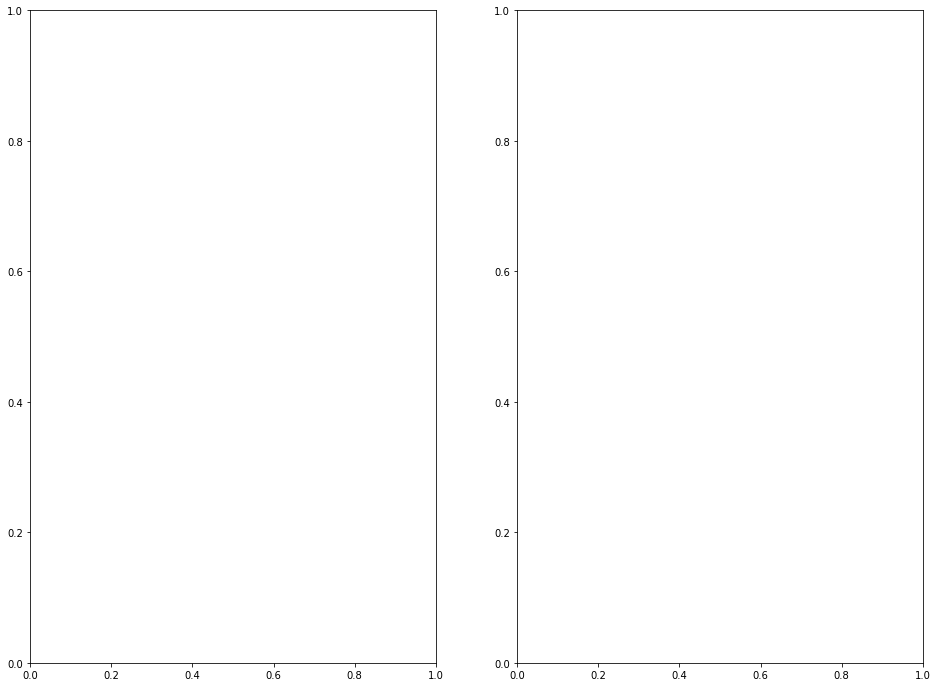

In [42]:
feature_set ='STUDENT_NON_ACTIONABLE'
year = 2019
level = 'regiao'
list_units = ['Centroeste', 'Norte', 'Sudeste', 'Sul', 'Nordeste']
#list_units = nordeste
metrics = ['fpr', 'fnr']

labels=["Northeast", "North", "Southeast","Midwest", "South"]

fig, ax = plt.subplots(1, 2, figsize=(16, 12))
#fig, ax = plt.subplots()
for i, value in enumerate(metrics):
        m1, m2, order = matrix (level, value, big_table, year, feature_set, list_units)
        #print(m1)

        mask = np.zeros_like(m1)
        mask[np.triu_indices_from(mask)] = True

        data_masked = np.ma.array(m1, mask=mask)
        sig_masked = np.ma.array(m2, mask=mask)
        #print(data_masked)
    
        im = ax[i].imshow(data_masked, cmap="YlGnBu", origin="upper")  

        ax[i].set_xticks(list(range(len(order))))
        ax[i].set_xticklabels(order)

        ax[i].set_yticks(list(range(len(order))))
        ax[i].set_yticklabels(order)
        
        indice =  '(a) ' if metrics[i] == 'fpr' else '(b) '
        ax[i].set_title(indice + value)
        crossout(np.argwhere(sig_masked.T < 0.05), ax=ax[i],scale=0.8, color="grey")
        fig.colorbar(im, ax=ax[i], cmap="YlGnBu", shrink=0.6)
        
        
plt.savefig('full_model_matrix-comparison_region.png', dpi=400)    
plt.show()

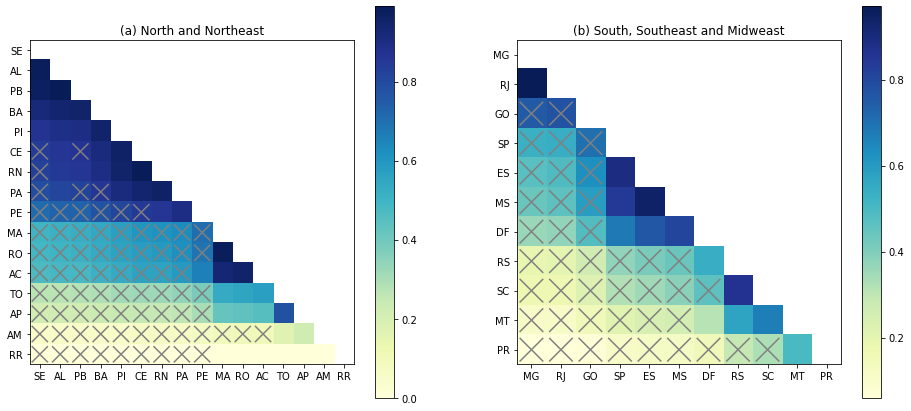

In [43]:
feature_set ='SCHOOL_STUDENT_TEACHER'
year = 2019
level = 'estado'
#list_units = ['Centroeste', 'Norte', 'Sudeste', 'Sul', 'Nordeste']
list_units = [nordeste+norte, sudeste+sul+centroeste]
metrics = 'fnr'

fig, ax = plt.subplots(1, 2, figsize=(16, 12))
#fig, ax = plt.subplots()
for i, estados in enumerate(list_units):
        m1, m2, order = matrix (level, metrics, big_table, year, feature_set, estados)
        #print(m1)

        mask = np.zeros_like(m1)
        mask[np.triu_indices_from(mask)] = True

        data_masked = np.ma.array(m1, mask=mask)
        sig_masked = np.ma.array(m2, mask=mask)
        #print(data_masked)
    
        im = ax[i].imshow(data_masked, cmap="YlGnBu", origin="upper")  

        ax[i].set_xticks(list(range(len(order))))
        ax[i].set_xticklabels(order)

        ax[i].set_yticks(list(range(len(order))))
        ax[i].set_yticklabels(order)
        
        indice =  '(a) North and Northeast' if i == 0 else '(b) South, Southeast and Midweast'
        ax[i].set_title(indice)
        crossout(np.argwhere(sig_masked.T < 0.05), ax=ax[i],scale=0.8, color="gray")
        fig.colorbar(im, ax=ax[i], cmap="YlGnBu", shrink=0.6)
        
        
plt.savefig('wo-nonactionable_model_matrix-comparison.png', dpi=400)    
plt.show()

In [145]:
df = build_df('estado', 'fnr',big_table, 2019)
df[norte+nordeste].loc['STUDENT'].sort_values(ascending = False)


,Model,F1_measure,AUC,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
FULL,RandomForestClassifier,0.73,0.80,7.0,17.0,3.0,5.0,200.0,139.0,8.0,45.0,92.0,19.0,462.0,14.0,14.0,79.0,96.0,126.0,56.0,16.0,138.0,49.0,21.0,0.0,39.0,24.0,52.0,79.0,15.0
SCHOOL,LogisticRegression,0.52,0.59,11.0,4.0,8.0,3.0,159.0,60.0,13.0,26.0,170.0,27.0,631.0,59.0,39.0,41.0,64.0,121.0,31.0,196.0,193.0,48.0,15.0,0.0,195.0,256.0,39.0,1188.0,23.0
STUDENT,AdaBoostClassifier,0.71,0.79,5.0,17.0,2.0,5.0,182.0,162.0,9.0,43.0,48.0,20.0,414.0,8.0,2.0,61.0,109.0,149.0,57.0,75.0,147.0,62.0,15.0,0.0,80.0,16.0,56.0,163.0,6.0
TEACHER,LogisticRegression,0.53,0.57,2.0,10.0,1.0,0.0,167.0,54.0,2.0,35.0,126.0,16.0,399.0,30.0,3.0,36.0,24.0,200.0,27.0,16.0,164.0,23.0,35.0,0.0,292.0,380.0,6.0,1212.0,29.0
NON_ACTIONABLE,AdaBoostClassifier,0.70,0.76,12.0,18.0,16.0,8.0,189.0,110.0,22.0,61.0,111.0,29.0,502.0,23.0,27.0,70.0,71.0,109.0,52.0,39.0,139.0,29.0,22.0,5.0,6.0,1.0,52.0,136.0,26.0
SCHOOL_STUDENT,LogisticRegression,0.72,0.80,6.0,18.0,1.0,7.0,177.0,114.0,20.0,36.0,95.0,28.0,342.0,24.0,3.0,78.0,116.0,147.0,60.0,13.0,174.0,61.0,15.0,0.0,53.0,17.0,54.0,106.0,14.0
SCHOOL_TEACHER,AdaBoostClassifier,0.51,0.59,8.0,2.0,8.0,1.0,163.0,40.0,5.0,26.0,166.0,20.0,449.0,38.0,27.0,34.0,56.0,149.0,31.0,37.0,150.0,37.0,20.0,0.0,310.0,351.0,28.0,1508.0,27.0
SCHOOL_NON_ACTIONABLE,RandomForestClassifier,0.69,0.76,13.0,13.0,18.0,6.0,208.0,113.0,29.0,46.0,120.0,36.0,445.0,16.0,33.0,81.0,84.0,127.0,61.0,28.0,176.0,39.0,18.0,5.0,24.0,9.0,54.0,292.0,22.0
STUDENT_TEACHER,AdaBoostClassifier,0.72,0.79,4.0,16.0,1.0,2.0,184.0,148.0,6.0,44.0,50.0,18.0,379.0,15.0,2.0,68.0,96.0,145.0,53.0,25.0,187.0,55.0,22.0,0.0,59.0,27.0,50.0,340.0,4.0
STUDENT_NON_ACTIONABLE,AdaBoostClassifier,0.73,0.80,4.0,18.0,3.0,6.0,176.0,149.0,7.0,38.0,66.0,22.0,447.0,13.0,8.0,64.0,100.0,109.0,55.0,62.0,133.0,51.0,17.0,1.0,34.0,14.0,52.0,122.0,11.0


In [155]:
dt =big_table[2019]["SCHOOL_STUDENT_TEACHER"]
dt[(dt.codigo_uf=="PA") | (dt.codigo_uf=="SE")]

,codigo_uf,model,tp,tn,fp,fn,f1,acc,fnr,fpr,auc_model,f1_model
39,PA,AdaBoostClassifier,27,300,17,58,0.418605,0.813433,0.682353,0.053628,0.794434,0.719341
40,PA,LogisticRegression,7,313,4,78,0.145833,0.796020,0.917647,0.012618,0.785301,0.714493
41,PA,RandomForestClassifier,12,310,7,73,0.230769,0.800995,0.858824,0.022082,0.791911,0.718366
72,SE,AdaBoostClassifier,8,83,2,49,0.238806,0.640845,0.859649,0.023529,0.794434,0.719341
73,SE,LogisticRegression,2,83,2,55,0.065574,0.598592,0.964912,0.023529,0.785301,0.714493
74,SE,RandomForestClassifier,9,80,5,48,0.253521,0.626761,0.842105,0.058824,0.791911,0.718366


In [26]:
#best political unit in a predefined thresold of schools above median
df_temp = pd.DataFrame()
for year in big_table.keys():
    table = big_table[year]['STUDENT'][['fnr','f1_model','codigo_uf', 'model']]
    for i in table.codigo_uf.unique():
        fnr = table[table.codigo_uf == i].groupby('codigo_uf').apply(
            lambda  x: x.loc[x.f1_model == x.f1_model.max()]).droplevel(0)['fnr'].iloc[0]
        df_temp.loc[i, year] = fnr
result_df = pd.DataFrame()
temp = df_proportion_class(DATA, 'Municipal+Estadual'
                           , 'estado')[0]
for i in df_temp.columns:
    dfin =df_temp[[i]]
    list_units = temp[(temp>0.2) & (temp < 0.8)][[i]].dropna().index.to_list()
    #print(list_units)
    result_list = dfin[dfin[[i]].index.isin(list_units)]
    #print(result)
    result_list = result_list.sort_values(by=[i],ascending = False).head(5).index
    result_df[i] = result_list
    #print(result)
dfao = result_df.apply(pd.Series.value_counts, axis=1).fillna(0)
for i in range (result_df.shape[0]):
    j = 5 -i
    dfao.loc[:i] = dfao.loc[:i] *j
dfao.sum().sort_values(ascending = False)

CE    870.0
PB    252.0
SE    174.0
PE    153.0
PA    150.0
BA     54.0
MG     10.0
RJ      9.0
RN      7.0
PI      2.0
ES      2.0
dtype: float64

In [313]:
big_table[2019]['FULL']

,codigo_uf,model,tp,tn,fp,fn,f1,acc,fnr,fpr,auc_model,f1_model
0,AC,AdaBoostClassifier,9,40,3,6,0.666667,0.844828,0.400000,0.069767,0.799492,0.724958
1,AC,LogisticRegression,6,41,2,9,0.521739,0.810345,0.600000,0.046512,0.785446,0.708419
2,AC,RandomForestClassifier,8,41,2,7,0.640000,0.844828,0.466667,0.046512,0.797660,0.725091
3,AL,AdaBoostClassifier,2,164,5,17,0.153846,0.882979,0.894737,0.029586,0.799492,0.724958
4,AL,LogisticRegression,1,167,2,18,0.090909,0.893617,0.947368,0.011834,0.785446,0.708419
...,...,...,...,...,...,...,...,...,...,...,...,...
76,SP,LogisticRegression,1723,203,1021,66,0.760203,0.639230,0.036892,0.834150,0.785446,0.708419
77,SP,RandomForestClassifier,1710,264,960,79,0.766988,0.655161,0.044159,0.784314,0.797660,0.725091
78,TO,AdaBoostClassifier,26,110,28,9,0.584270,0.786127,0.257143,0.202899,0.799492,0.724958
79,TO,LogisticRegression,19,121,17,16,0.535211,0.809249,0.457143,0.123188,0.785446,0.708419


CE    848.0
SE    325.0
BA    154.0
PA    153.0
PB    120.0
PE     55.0
MG     14.0
PI      6.0
ES      3.0
RJ      2.0
GO      2.0
RN      1.0
dtype: float64

In [274]:
for i in range(1):
    j = i+1
    print(result_df[:j].T[i].value_counts()

CE    7
SE    2
BA    1
PA    1
Name: 0, dtype: int64


In [266]:
result_df[:1].T[0].value_counts()

CE    7
SE    2
BA    1
PA    1
Name: 0, dtype: int64

In [57]:
df_temp[2009].

PI    1.000000
CE    0.977778
PA    0.931624
PB    0.865385
BA    0.857143
Name: 2009, dtype: float64

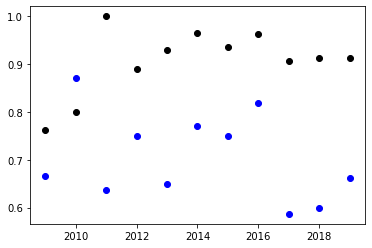

In [139]:
from scipy.stats import linregress
x = abs(df_temp.loc['SE'].to_numpy() - df_temp.loc['RN'].to_numpy())
y = abs(df_temp.columns.to_numpy() - 
#linregress(x,y)
#plt.scatter(y, x, color="black")
x = df_temp.loc['RN'].to_numpy()
y = df_temp.columns.to_numpy()
#linregress(x,y)
plt.scatter(y, x, color="blue")

In [113]:
df_temp.columns.to_numpy()


array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [37]:
big_table[2015]['STUDENT_NON_ACTIONABLE']

,codigo_uf,model,tp,tn,fp,fn,f1,acc,fnr,fpr,auc_model,f1_model
0,AC,AdaBoostClassifier,4,42,2,7,0.470588,0.836364,0.636364,0.045455,0.801845,0.729483
1,AC,LogisticRegression,3,43,1,8,0.400000,0.836364,0.727273,0.022727,0.809070,0.732288
2,AC,RandomForestClassifier,3,39,5,8,0.315789,0.763636,0.727273,0.113636,0.799035,0.721988
3,AL,AdaBoostClassifier,1,159,1,9,0.166667,0.941176,0.900000,0.006250,0.801845,0.729483
4,AL,LogisticRegression,1,160,0,9,0.181818,0.947059,0.900000,0.000000,0.809070,0.732288
...,...,...,...,...,...,...,...,...,...,...,...,...
76,SP,LogisticRegression,2213,232,1098,83,0.789370,0.674297,0.036150,0.825564,0.809070,0.732288
77,SP,RandomForestClassifier,2156,285,1045,140,0.784428,0.673194,0.060976,0.785714,0.799035,0.721988
78,TO,AdaBoostClassifier,17,150,15,5,0.629630,0.893048,0.227273,0.090909,0.801845,0.729483
79,TO,LogisticRegression,19,150,15,3,0.678571,0.903743,0.136364,0.090909,0.809070,0.732288


In [35]:
b =big_table[2019]['FULL'][['tn', 'tp','fp','fn', 'fpr', 'fnr', 'model', 'codigo_uf']]
b = b.loc[b.model=='RandomForestClassifier']
b

,tn,tp,fp,fn,fpr,fnr,model,codigo_uf
2,41,8,2,7,0.046512,0.466667,RandomForestClassifier,AC
5,166,2,3,17,0.017751,0.894737,RandomForestClassifier,AL
8,154,21,34,3,0.180851,0.125000,RandomForestClassifier,AM
11,42,6,8,5,0.160000,0.454545,RandomForestClassifier,AP
14,603,39,4,200,0.006590,0.836820,RandomForestClassifier,BA
17,447,46,3,139,0.006667,0.751351,RandomForestClassifier,CE
20,11,63,4,8,0.266667,0.112676,RandomForestClassifier,DF
23,60,110,29,45,0.325843,0.290323,RandomForestClassifier,ES
26,190,137,52,92,0.214876,0.401747,RandomForestClassifier,GO
29,403,28,10,19,0.024213,0.404255,RandomForestClassifier,MA


In [36]:
a =big_table[2019]['SCHOOL_STUDENT_TEACHER'][['tn', 'tp','fp','fn', 'fpr', 'fnr', 'model', 'codigo_uf']]
a = a.loc[a.model=='RandomForestClassifier']
a

,tn,tp,fp,fn,fpr,fnr,model,codigo_uf
2,38,13,5,2,0.116279,0.133333,RandomForestClassifier,AC
5,167,3,2,16,0.011834,0.842105,RandomForestClassifier,AL
8,129,23,59,1,0.313830,0.041667,RandomForestClassifier,AM
11,42,7,8,4,0.160000,0.363636,RandomForestClassifier,AP
14,596,59,11,180,0.018122,0.753138,RandomForestClassifier,BA
17,446,67,4,118,0.008889,0.637838,RandomForestClassifier,CE
20,8,65,7,6,0.466667,0.084507,RandomForestClassifier,DF
23,60,119,29,36,0.325843,0.232258,RandomForestClassifier,ES
26,179,161,63,68,0.260331,0.296943,RandomForestClassifier,GO
29,400,24,13,23,0.031477,0.489362,RandomForestClassifier,MA


In [69]:
a.head()

,tn,tp,fp,fn,fpr,fnr,model,codigo_uf
2,40,3,3,12,0.069767,0.800000,RandomForestClassifier,AC
5,144,5,25,14,0.147929,0.736842,RandomForestClassifier,AL
8,183,7,5,17,0.026596,0.708333,RandomForestClassifier,AM
11,37,6,13,5,0.260000,0.454545,RandomForestClassifier,AP
14,602,10,5,229,0.008237,0.958159,RandomForestClassifier,BA


In [91]:
#df.iloc[i]['c1']
#df.loc[nk, 'Model'] = model
a.loc[2,'tn']
#df.iloc[0]['year']
a

,tn,tp,fp,fn,fpr,fnr,model,codigo_uf
2,24,2,6,6,0.200000,0.750000,RandomForestClassifier,AC
5,80,6,14,12,0.148936,0.666667,RandomForestClassifier,AL
8,145,6,8,16,0.052288,0.727273,RandomForestClassifier,AM
11,27,4,0,5,0.000000,0.555556,RandomForestClassifier,AP
14,493,31,23,158,0.044574,0.835979,RandomForestClassifier,BA
17,298,20,16,70,0.050955,0.777778,RandomForestClassifier,CE
20,7,39,8,17,0.533333,0.303571,RandomForestClassifier,DF
23,98,50,48,44,0.328767,0.468085,RandomForestClassifier,ES
26,220,54,25,109,0.102041,0.668712,RandomForestClassifier,GO
29,220,12,22,29,0.090909,0.707317,RandomForestClassifier,MA


In [81]:
# Is there differences between the full model to the version without one set of features set?
#A model blinded to an underlying feature set and its FNR increase regarding the full set, 
#suggest that the state have good policies in the direction of the feature set.
# If FPR increase, that the model have a lack of policies regarding this feature set
df = pd.DataFrame(columns = {'year', 'pvalue', 'uf'})
j=0
for year in big_table.keys():
    full =big_table[year]['FULL'][['tn', 'tp','fp','fn', 'fpr', 'fnr', 'model', 'codigo_uf']]
    full = full.loc[full.model=='RandomForestClassifier']
    full_wset =big_table[year]['SCHOOL_STUDENT_NON_ACTIONABLE'][['tn', 'tp','fp','fn', 'fpr', 'fnr', 'model', 'codigo_uf']]
    full_wset = full_wset.loc[full_wset.model=='RandomForestClassifier']


    for i in full.codigo_uf.values:
        
        fn = full_wset.loc[full_wset.codigo_uf == i]['fn'].values[0]
        fn_ref =full.loc[full.codigo_uf == i]['fn'].values[0]
    
        tp = full_wset.loc[full_wset.codigo_uf == i]['tp'].values[0]
        tp_ref =full.loc[full.codigo_uf == i]['tp'].values[0]
        
        fnr = full_wset.loc[full_wset.codigo_uf == i]['fnr'].values[0]
        fnr_ref =full.loc[full.codigo_uf == i]['fnr'].values[0]        
        #print(fnr)
    
        table = [[fn, tp],[tp_ref, fn_ref]]
        #print(table)
        result = mcnemar(table, exact=False, correction=True)
        #if (result.pvalue < 0.005):
        df.loc[j, 'year']= year
        df.loc[j,'pvalue'] = result.pvalue
        df.loc[j, 'uf'] = i
        if (fnr_ref < fnr):
                df.loc[j, 'direction'] = 'decrease' 
        else: 
                df.loc[j, 'direction'] ='increase'
            #print(i)
            #print('mcnemar pvalue=%.4f' % (result.pvalue))
        j+=1
# interpret the p-value
#df.groupby('uf')['year', 'direction'].count().sort_values(by='year',ascending=False)    

In [79]:
#Are reg change larger?
full =big_table[2016]['FULL'][['tn', 'tp','fp','fn', 'fpr', 'fnr', 'model', 'codigo_uf']]
full = full.loc[full.model=='RandomForestClassifier']
full_wset =big_table[2016]['SCHOOL_STUDENT_NON_ACTIONABLE'][['tn', 'tp','fp','fn', 'fpr', 'fnr', 'model', 'codigo_uf']]
full_wset = full_wset.loc[full_wset.model=='RandomForestClassifier']

reg = 'SP'
iterrs =  np.delete(a.codigo_uf.values, np.where(a.codigo_uf.values == reg))
for i in iterrs:
    fp_ch_ref = abs(full.loc[full.codigo_uf==i]['fp'] - full_wset.loc[full_wset.codigo_uf==i]['fp'])
    fp_ch = abs(full.loc[full.codigo_uf==reg]['fp'] - full_wset.loc[full_wset.codigo_uf==reg]['fp'])
    
    fp_ref =  full.loc[full.codigo_uf==i]['fp']
    fp = full.loc[full.codigo_uf==reg]['fp']
    
    tn_ref = full.loc[full.codigo_uf==i]['tn']
    tn = full.loc[full.codigo_uf==reg]['tn']
    
    count = [fp_ch , fp_ch_ref]
    nobs = [fp + tn, fp_ref + tn_ref]
#alternative = 'larger' if one_sided else 'two-sided'
    stat, pval = zt(count, nobs, alternative="larger")
    print(i, pval.round(5))

AC [0.1362]
AL [0.00075]
AM [0.00088]
AP [0.39033]
BA [0.]
CE [0.]
DF [0.9728]
ES [0.0434]
GO [0.87307]
MA [0.]
MG [0.]
MS [0.01995]
MT [0.00881]
PA [0.00099]
PB [1.e-05]
PE [0.]
PI [4.e-05]
PR [0.9998]
RJ [0.02245]
RN [0.00025]
RO [0.09114]
RR [0.03958]
RS [0.53193]
SC [0.07351]
SE [0.00596]
TO [0.04759]


In [82]:
df[df.pvalue <=0.005]

,pvalue,year,uf,direction
21,0,2009,RR,increase
69,0,2011,PI,increase
111,0.00129936,2013,BA,increase


In [78]:
# Is there differences between the full model to the version without one set of features set?
#A model blinded to an underlying feature set and its FNR increase regarding the full set, 
#suggest that the state have good policies in the direction of the feature set.
# If FPR increase, that the model have a lack of policies regarding this feature set
df = pd.DataFrame(columns = {'year', 'pvalue', 'uf'})
j=0
for year in big_table.keys():
    b =big_table[year]['FULL'][['tn', 'tp','fp','fn', 'fpr', 'fnr', 'model', 'codigo_uf']]
    b = b.loc[b.model=='RandomForestClassifier']
    a =big_table[year]['SCHOOL_STUDENT_NON_ACTIONABLE'][['tn', 'tp','fp','fn', 'fpr', 'fnr', 'model', 'codigo_uf']]
    a = a.loc[a.model=='RandomForestClassifier']


    for i in a.codigo_uf.values:
        
        fn = a.loc[a.codigo_uf == i]['fn']
        fn_ref =b.loc[b.codigo_uf == i]['fn']  
           
    
        tp = a.loc[a.codigo_uf == i]['tp']
        tp_ref =b.loc[b.codigo_uf == i]['tp'] 
        
        fnr = a.loc[a.codigo_uf == i]['fnr']
        fnr_ref =b.loc[b.codigo_uf == i]['fnr']  
    
        table = [[fn, tp],[tp_ref, fn_ref]]
    #print(table)
        result = mcnemar(table, exact=False, correction=True)
        if (result.pvalue < 0.005):
            df.loc[j, 'year']= year
            df.loc[j,'pvalue'] = result.pvalue
            df.loc[j, 'uf'] = i
            
            #print(i)
            #print('mcnemar pvalue=%.4f' % (result.pvalue))
            j+=1
# interpret the p-value
df.groupby('uf')['year'].count().sort_values(ascending=False)  

uf
RR    1
PI    1
BA    1
Name: year, dtype: int64

80    0.152174
Name: fpr, dtype: float64

In [7]:
for i in a.regiao.values:
    print(i)
    fp = a.loc[a.regiao == i]['fp']
    fp_ref =b.loc[b.regiao == i]['fp']  
    
    tn = a.loc[a.regiao == i]['tn']
    tn_ref =b.loc[b.regiao == i]['tn'] 
    
    table = [[fp, tn],[tn_ref, fp_ref]]
    #print(table)
    result = mcnemar(table, exact=False, correction=True)
    print('mcnemar pvalue=%.4f' % (result.pvalue))

Centroeste
mcnemar pvalue=0.0000
Nordeste
mcnemar pvalue=0.0000
Norte
mcnemar pvalue=0.3629
Sudeste
mcnemar pvalue=0.0001
Sul
mcnemar pvalue=0.7210


In [13]:
#What regions have a greater change?
reg = "Sul"
iterrs =  np.delete(a.regiao.values, np.where(a.regiao.values == reg))
for i in iterrs:
    fp_ch_ref = abs(a.loc[a.regiao==i]['fn'] - b.loc[b.regiao==i]['fn'])
    fp_ch = abs(a.loc[a.regiao==reg]['fn'] - b.loc[b.regiao==reg]['fn'])
    
    fp_ref =  a.loc[a.regiao==i]['fn']
    fp = a.loc[a.regiao==reg]['fn']
    
    tn_ref = a.loc[a.regiao==i]['tp']
    tn = a.loc[a.regiao==reg]['tp']
    #print(fp_ch_ref)
    count = [fp_ch_ref , fp_ch]
    nobs = [fp_ref + tn_ref, fp + tn]
#alternative = 'larger' if one_sided else 'two-sided'
    stat, pval = zt(count, nobs, alternative="larger")
    print(i, stat, pval.round(5))

NotImplementedError: more than two samples are not implemented yet

In [38]:
# What's region is more far from the southeast region in the whole period considering all variables?
for year in big_table.keys():
    table = big_table[year]['FULL'][['f1','regiao']].fillna(0)
    f1_base =  table[table['regiao']=="Sudeste"]['f1'].values[0]
    table['f1'] = table['f1'] - f1_base

    print(table.reindex(table.f1.abs().sort_values(ascending=False).index).iloc[:1])



        f1    regiao
1 -0.31504  Nordeste
         f1    regiao
1 -0.364981  Nordeste
         f1    regiao
1 -0.351366  Nordeste
         f1    regiao
1 -0.375737  Nordeste
         f1    regiao
1 -0.385511  Nordeste
         f1    regiao
1 -0.409737  Nordeste
         f1    regiao
1 -0.421132  Nordeste
         f1    regiao
1 -0.427358  Nordeste
         f1    regiao
1 -0.368515  Nordeste
         f1    regiao
1 -0.407641  Nordeste
         f1    regiao
1 -0.447757  Nordeste


In [39]:
# What's region is more far from the southeast region in the whole period considering all variables whitout non-actionables?
for year in big_table.keys():
    table = big_table[year]['SCHOOL_STUDENT_TEACHER'][['f1','regiao']].fillna(0)
    f1_base =  table[table['regiao']=="Sudeste"]['f1'].values[0]
    table['f1'] = table['f1'] - f1_base

    print(table.reindex(table.f1.abs().sort_values(ascending=False).index).iloc[:1])

         f1    regiao
1 -0.284553  Nordeste
         f1    regiao
1 -0.339651  Nordeste
         f1    regiao
1 -0.330462  Nordeste
         f1    regiao
1 -0.344517  Nordeste
         f1    regiao
1 -0.370549  Nordeste
        f1    regiao
1 -0.42198  Nordeste
         f1    regiao
1 -0.379208  Nordeste
         f1    regiao
1 -0.436447  Nordeste
        f1    regiao
1 -0.36779  Nordeste
         f1    regiao
1 -0.408867  Nordeste
         f1    regiao
1 -0.411776  Nordeste


In [40]:
#all variables whithout teacher
for year in big_table.keys():
    table = big_table[year]['SCHOOL_STUDENT_NON_ACTIONABLE'][['f1','regiao']].fillna(0)
    f1_base =  table[table['regiao']=="Sudeste"]['f1'].values[0]
    table['f1'] = table['f1'] - f1_base

    print(table.reindex(table.f1.abs().sort_values(ascending=False).index).iloc[:1])

       f1    regiao
1 -0.3067  Nordeste
         f1    regiao
1 -0.321153  Nordeste
         f1    regiao
1 -0.320313  Nordeste
         f1    regiao
1 -0.352969  Nordeste
         f1    regiao
1 -0.369806  Nordeste
         f1    regiao
1 -0.408394  Nordeste
         f1    regiao
1 -0.404866  Nordeste
         f1    regiao
1 -0.429864  Nordeste
         f1    regiao
1 -0.355019  Nordeste
         f1    regiao
1 -0.403857  Nordeste
         f1    regiao
1 -0.471195  Nordeste


In [27]:
#all variables whitout students?
for year in big_table.keys():
    table = big_table[year]['SCHOOL_TEACHER_NON_ACTIONABLE'][['f1','regiao']].fillna(0)
    f1_base =  table[table['regiao']=="Sudeste"]['f1'].values[0]
    table['f1'] = table['f1'] - f1_base

    print(table.reindex(table.f1.abs().sort_values(ascending=False).index).iloc[:1])

         f1 regiao
2 -0.419893  Norte
         f1 regiao
2 -0.457164  Norte
         f1 regiao
2 -0.376239  Norte
         f1 regiao
2 -0.453383  Norte
         f1 regiao
2 -0.392294  Norte
         f1 regiao
2 -0.440767  Norte
         f1 regiao
2 -0.352574  Norte
         f1 regiao
2 -0.357072  Norte
         f1 regiao
2 -0.339965  Norte
         f1 regiao
2 -0.387106  Norte
         f1 regiao
2 -0.246545  Norte


In [28]:
# What's region is do less from the southeast region in the whole period considering all variables?
for year in big_table.keys():
    table = big_table[year]['FULL'][['fpr','regiao']].fillna(0)
    print(table.reindex(table.fpr.sort_values(ascending=False).index).iloc[:1])



       fpr regiao
4  0.83181    Sul
        fpr regiao
4  0.757781    Sul
        fpr regiao
4  0.797122    Sul
        fpr regiao
4  0.691643    Sul
        fpr regiao
4  0.762599    Sul
        fpr regiao
4  0.752294    Sul
        fpr regiao
4  0.768293    Sul
        fpr regiao
4  0.808132    Sul
        fpr regiao
4  0.814286    Sul
        fpr regiao
4  0.743883    Sul
        fpr regiao
4  0.837937    Sul


In [29]:
# What's region is do less from the southeast region in the whole period considering all variables?
for year in big_table.keys():
    table = big_table[year]['FULL'][['fnr','regiao']].fillna(0)
    print(table.reindex(table.fnr.sort_values(ascending=False).index).iloc[:1])



        fnr    regiao
1  0.709516  Nordeste
        fnr    regiao
1  0.757202  Nordeste
        fnr    regiao
1  0.697248  Nordeste
        fnr    regiao
1  0.736025  Nordeste
        fnr    regiao
1  0.775623  Nordeste
        fnr    regiao
1  0.773558  Nordeste
        fnr    regiao
1  0.819613  Nordeste
        fnr    regiao
1  0.821822  Nordeste
        fnr    regiao
1  0.784861  Nordeste
        fnr    regiao
1  0.774949  Nordeste
        fnr    regiao
1  0.890173  Nordeste


In [155]:
# What's region is do less from the southeast region in the whole period considering all variables?
for year in big_table.keys():
    table = big_table[year]['SCHOOL_STUDENT_TEACHER'][['fnr','regiao']].fillna(0)
    print(table.reindex(table.fnr.sort_values(ascending=False).index).iloc[:1])

        fnr    regiao
1  0.839733  Nordeste
        fnr    regiao
1  0.798354  Nordeste
        fnr    regiao
1  0.816514  Nordeste
        fnr    regiao
1  0.830745  Nordeste
       fnr    regiao
1  0.84072  Nordeste
        fnr    regiao
1  0.860759  Nordeste
        fnr    regiao
1  0.847458  Nordeste
        fnr    regiao
1  0.814815  Nordeste
        fnr    regiao
1  0.823705  Nordeste
        fnr    regiao
1  0.817719  Nordeste
        fnr    regiao
1  0.825626  Nordeste


In [31]:
# What's region is do less from the southeast region in the whole period considering all variables?
for year in big_table.keys():
    table = big_table[year]['SCHOOL_STUDENT_NON_ACTIONABLE'][['fnr','regiao']].fillna(0)
    print(table.reindex(table.fnr.sort_values(ascending=False).index).iloc[:1])

        fnr    regiao
1  0.682805  Nordeste
        fnr    regiao
1  0.685185  Nordeste
        fnr    regiao
1  0.721101  Nordeste
        fnr    regiao
1  0.796584  Nordeste
        fnr    regiao
1  0.772853  Nordeste
        fnr    regiao
1  0.807314  Nordeste
        fnr    regiao
1  0.766344  Nordeste
        fnr    regiao
1  0.812813  Nordeste
       fnr    regiao
1  0.76992  Nordeste
        fnr    regiao
1  0.786151  Nordeste
        fnr    regiao
1  0.905588  Nordeste


In [32]:
# What's region is do less from the southeast region in the whole period considering all variables?
for year in big_table.keys():
    table = big_table[year]['SCHOOL_STUDENT_NON_ACTIONABLE'][['fnr','regiao']].fillna(0)
    print(table.reindex(table.fnr.sort_values(ascending=False).index).iloc[:1])

        fnr    regiao
1  0.682805  Nordeste
        fnr    regiao
1  0.685185  Nordeste
        fnr    regiao
1  0.721101  Nordeste
        fnr    regiao
1  0.796584  Nordeste
        fnr    regiao
1  0.772853  Nordeste
        fnr    regiao
1  0.807314  Nordeste
        fnr    regiao
1  0.766344  Nordeste
        fnr    regiao
1  0.812813  Nordeste
       fnr    regiao
1  0.76992  Nordeste
        fnr    regiao
1  0.786151  Nordeste
        fnr    regiao
1  0.905588  Nordeste


In [33]:
# What's region is do less from the southeast region in the whole period considering all variables?
for year in big_table.keys():
    table = big_table[year]['STUDENT_TEACHER_NON_ACTIONABLE'][['fnr','regiao']].fillna(0)
    print(table.reindex(table.fnr.sort_values(ascending=False).index).iloc[:1])

        fnr    regiao
1  0.767947  Nordeste
        fnr    regiao
1  0.833333  Nordeste
        fnr    regiao
1  0.822018  Nordeste
        fnr    regiao
1  0.861801  Nordeste
        fnr    regiao
1  0.807479  Nordeste
        fnr    regiao
1  0.846695  Nordeste
        fnr    regiao
1  0.845036  Nordeste
        fnr    regiao
1  0.877878  Nordeste
        fnr    regiao
1  0.838645  Nordeste
        fnr    regiao
1  0.854379  Nordeste
        fnr    regiao
1  0.881503  Nordeste


In [122]:
big_table[2019]['FULL']


,codigo_uf,model,tp,tn,fp,fn,f1,acc,fnr,fpr,auc_model,f1_model
0,AC,AdaBoostClassifier,9,40,3,6,0.666667,0.844828,0.400000,0.069767,0.799492,0.724958
1,AC,LogisticRegression,6,41,2,9,0.521739,0.810345,0.600000,0.046512,0.785446,0.708419
2,AC,RandomForestClassifier,8,41,2,7,0.640000,0.844828,0.466667,0.046512,0.797660,0.725091
3,AL,AdaBoostClassifier,2,164,5,17,0.153846,0.882979,0.894737,0.029586,0.799492,0.724958
4,AL,LogisticRegression,1,167,2,18,0.090909,0.893617,0.947368,0.011834,0.785446,0.708419
...,...,...,...,...,...,...,...,...,...,...,...,...
76,SP,LogisticRegression,1723,203,1021,66,0.760203,0.639230,0.036892,0.834150,0.785446,0.708419
77,SP,RandomForestClassifier,1710,264,960,79,0.766988,0.655161,0.044159,0.784314,0.797660,0.725091
78,TO,AdaBoostClassifier,26,110,28,9,0.584270,0.786127,0.257143,0.202899,0.799492,0.724958
79,TO,LogisticRegression,19,121,17,16,0.535211,0.809249,0.457143,0.123188,0.785446,0.708419


In [115]:
build_df('estado','fnr', big_table, 2019)

,Model,F1_measure,AUC,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
FULL,RandomForestClassifier,0.73,0.80,0.47,0.89,0.12,0.45,0.84,0.75,0.11,0.29,0.40,0.40,0.44,0.11,0.19,0.93,0.79,0.56,0.84,0.03,0.32,0.64,0.40,0.0,0.06,0.06,0.91,0.04,0.43
SCHOOL,LogisticRegression,0.52,0.59,0.73,0.21,0.33,0.27,0.67,0.32,0.18,0.17,0.74,0.57,0.60,0.48,0.53,0.48,0.53,0.54,0.46,0.35,0.45,0.62,0.29,0.0,0.31,0.65,0.68,0.66,0.66
STUDENT,AdaBoostClassifier,0.71,0.79,0.33,0.89,0.08,0.45,0.76,0.88,0.13,0.28,0.21,0.43,0.39,0.07,0.03,0.72,0.90,0.66,0.85,0.13,0.34,0.81,0.29,0.0,0.13,0.04,0.98,0.09,0.17
TEACHER,LogisticRegression,0.53,0.57,0.13,0.53,0.04,0.00,0.70,0.29,0.03,0.23,0.55,0.34,0.38,0.24,0.04,0.42,0.20,0.88,0.40,0.03,0.38,0.30,0.67,0.0,0.47,0.97,0.11,0.68,0.83
NON_ACTIONABLE,AdaBoostClassifier,0.70,0.76,0.80,0.95,0.67,0.73,0.79,0.59,0.31,0.39,0.48,0.62,0.48,0.19,0.36,0.82,0.59,0.48,0.78,0.07,0.32,0.38,0.42,1.0,0.01,0.00,0.91,0.08,0.74
SCHOOL_STUDENT,LogisticRegression,0.72,0.80,0.40,0.95,0.04,0.64,0.74,0.62,0.28,0.23,0.41,0.60,0.33,0.20,0.04,0.92,0.96,0.65,0.90,0.02,0.40,0.79,0.29,0.0,0.09,0.04,0.95,0.06,0.40
SCHOOL_TEACHER,AdaBoostClassifier,0.51,0.59,0.53,0.11,0.33,0.09,0.68,0.22,0.07,0.17,0.72,0.43,0.43,0.31,0.36,0.40,0.46,0.66,0.46,0.07,0.35,0.48,0.38,0.0,0.50,0.89,0.49,0.84,0.77
SCHOOL_NON_ACTIONABLE,RandomForestClassifier,0.69,0.76,0.87,0.68,0.75,0.55,0.87,0.61,0.41,0.30,0.52,0.77,0.42,0.13,0.45,0.95,0.69,0.56,0.91,0.05,0.41,0.51,0.35,1.0,0.04,0.02,0.95,0.16,0.63
STUDENT_TEACHER,AdaBoostClassifier,0.72,0.79,0.27,0.84,0.04,0.18,0.77,0.80,0.08,0.28,0.22,0.38,0.36,0.12,0.03,0.80,0.79,0.64,0.79,0.04,0.43,0.71,0.42,0.0,0.10,0.07,0.88,0.19,0.11
STUDENT_NON_ACTIONABLE,AdaBoostClassifier,0.73,0.80,0.27,0.95,0.12,0.55,0.74,0.81,0.10,0.25,0.29,0.47,0.42,0.11,0.11,0.75,0.83,0.48,0.82,0.11,0.31,0.66,0.33,0.2,0.05,0.04,0.91,0.07,0.31


In [251]:
mun_est = DATA[DATA.IN_TP_ESCOLA == "Municipal+Estadual"]
mun_est_y = mun_est[mun_est.CO_ANO==2019][['regiao', 'NU_NOTA_GERAL']]
mun_est_y['target']= build_target(mun_est_y).to_numpy()


50.0 % lowers quartis


In [252]:
sf = mun_est_y.groupby('regiao')['target'].sum()/mun_est_y.groupby('regiao')['target'].count()
drame = pd.DataFrame({'Regions':sf.index, 'Good_schools':sf.values})
drame['Bad_schools'] = (drame['Good_schools'] -1) *-1
drame

,Regions,Good_schools,Bad_schools
0,Centroeste,0.487255,0.512745
1,Nordeste,0.273014,0.726986
2,Norte,0.213547,0.786453
3,Sudeste,0.619487,0.380513
4,Sul,0.744471,0.255529


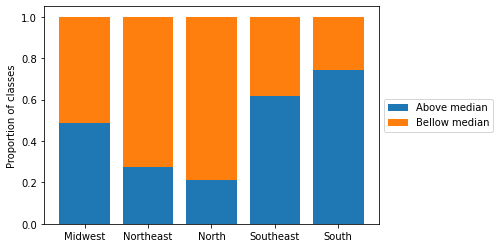

In [253]:
fig, ax = plt.subplots()
xlabels = ['Midwest', 'Northeast', 'North', 'Southeast','South']
ax.bar(xlabels, drame.Good_schools, label = "Above median" )
ax.bar(xlabels, drame.Bad_schools,  bottom=drame.Good_schools,label= "Bellow median")
ax.set_ylabel('Proportion of classes')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [171]:
DATA.loc[DATA.codigo_uf.isin(['BA', 'AL', 'SE', 'PE','CE','MA','RN','PI','PB'])]

,CO_ANO,IN_TP_ESCOLA,codigo_uf,regiao,IN_LABORATORIO_CIENCIAS,IN_SALA_ATENDIMENTO_ESPECIAL,IN_BIBLIOTECA,IN_SALA_LEITURA,IN_BANHEIRO,IN_BANHEIRO_PNE,QT_SALAS_UTILIZADAS,QT_EQUIP_TV,QT_EQUIP_DVD,QT_EQUIP_COPIADORA,QT_EQUIP_IMPRESSORA,QT_COMP_ALUNO,IN_BANDA_LARGA,QT_FUNCIONARIOS,IN_ALIMENTACAO,IN_SALA_PROFESSOR,IN_COZINHA,IN_EQUIP_PARABOLICA,IN_QUADRA_ESPORTES,IN_ATIV_COMPLEMENTAR,QT_MATRICULAS,IN_COMUM_MEDIO_INTEGRADO,TITULACAO,IN_FORM_DOCENTE,NU_LICENCIADOS,NU_CIENCIA_NATUREZA,NU_CIENCIAS_HUMANAS,NU_LINGUAGENS_CODIGOS,NU_MATEMATICA,NU_ESCOLAS,DIVERSIDADE,RENDA_PERCAPITA,EDU_PAI,EDU_MAE,NU_IDADE,TP_COR_RACA_1.0,TP_SEXO,TP_COR_RACA_2.0,TP_COR_RACA_3.0,TP_COR_RACA_4.0,TP_COR_RACA_5.0,NU_NOTA_GERAL
133806,2009,Municipal+Estadual,BA,Nordeste,1.0,0.0,1.0,0.0,1.0,0.0,10.0,1,1,1,1,10.0,1.0,38.0,0.0,1.0,0.0,1.0,0.0,0.0,30.0,0.0,0.047619,0.440909,1.000000,0.238095,0.285714,0.380952,0.095238,1.000000,0.238095,437.726852,0.962963,1.814815,18.222222,0.037037,0.259259,0.148148,0.814815,0.000000,0.000000,449.174815
133807,2009,Privada,BA,Nordeste,0.0,1.0,0.0,0.0,1.0,0.0,7.0,1,1,1,1,10.0,1.0,38.0,0.0,1.0,1.0,0.0,0.0,0.0,24.0,0.0,0.166667,0.666667,1.000000,0.187500,0.312500,0.312500,0.187500,2.600000,0.750000,2353.029412,2.676471,3.029412,18.117647,0.147059,0.264706,0.088235,0.558824,0.029412,0.000000,607.398824
133808,2009,Privada,BA,Nordeste,1.0,1.0,1.0,0.0,1.0,1.0,11.0,1,1,1,1,12.0,1.0,44.0,0.0,1.0,1.0,0.0,1.0,0.0,14.0,0.0,0.059524,0.616883,0.857143,0.121212,0.272727,0.393939,0.212121,1.190476,0.424242,1520.403333,1.560000,2.280000,17.600000,0.200000,0.520000,0.160000,0.320000,0.000000,0.000000,534.815200
133809,2009,Municipal+Estadual,BA,Nordeste,0.0,0.0,0.0,0.0,1.0,0.0,12.0,1,1,1,1,10.0,0.0,92.0,1.0,1.0,1.0,1.0,0.0,0.0,28.0,0.0,0.247863,0.727652,0.972973,0.184211,0.289474,0.368421,0.157895,1.540541,0.973684,1247.634538,2.337349,2.674699,17.927711,0.192771,0.481928,0.265060,0.433735,0.024096,0.024096,537.136867
133810,2009,Municipal+Estadual,BA,Nordeste,1.0,0.0,1.0,0.0,1.0,1.0,12.0,1,1,0,1,16.0,0.0,77.0,0.0,1.0,1.0,1.0,1.0,0.0,43.9,0.0,0.266667,0.818182,0.933333,0.244444,0.266667,0.377778,0.111111,1.511111,1.000000,787.554932,1.746939,2.048980,18.195918,0.195918,0.330612,0.191837,0.457143,0.024490,0.020408,506.406939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208779,2019,Municipal+Estadual,MA,Nordeste,0.0,0.0,0.0,0.0,1.0,0.0,6.0,1,1,1,1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,34.0,0.0,0.051282,0.636364,0.615385,0.230769,0.230769,0.384615,0.153846,1.153846,1.000000,111.836806,0.833333,1.500000,17.583333,0.083333,0.583333,0.250000,0.666667,0.000000,0.000000,458.056667
208780,2019,Municipal+Estadual,MA,Nordeste,0.0,0.0,0.0,0.0,1.0,1.0,9.0,1,1,1,1,0.0,1.0,10.0,1.0,1.0,1.0,0.0,0.0,0.0,27.5,0.0,0.230769,0.636364,0.923077,0.285714,0.285714,0.285714,0.142857,1.230769,0.928571,155.128472,0.166667,0.500000,17.875000,0.166667,0.333333,0.125000,0.375000,0.000000,0.000000,456.763333
208781,2019,Municipal+Estadual,MA,Nordeste,0.0,0.0,0.0,1.0,1.0,0.0,7.0,1,0,1,0,6.0,1.0,10.0,1.0,1.0,1.0,1.0,0.0,0.0,27.0,0.0,0.079365,0.590909,0.888889,0.300000,0.300000,0.300000,0.100000,1.277778,0.900000,199.141667,0.400000,1.200000,17.600000,0.100000,0.300000,0.300000,0.600000,0.000000,0.000000,430.120000
208783,2019,Municipal+Estadual,MA,Nordeste,0.0,0.0,0.0,0.0,1.0,1.0,5.0,1,0,0,1,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,21.5,0.0,0.142857,0.704545,0.857143,0.235294,0.352941,0.352941,0.058824,1.142857,0.823529,515.376984,1.285714,2.047619,17.380952,0.333333,0.285714,0.285714,0.380952,0.000000,0.000000,448.142857


In [22]:
# Reorder it following the values of the first value:
DATATESTE = DATA.loc[DATA.codigo_uf.isin(top_10_notas)]
    #['BA', 'AL', 'SE', 'PE','CE','MA','RN','PI','PB'])]

final = df_proportion_class(DATATESTE, 'Municipal+Estadual', 'estado')[0]
ordered_final = final.sort_values(by=2009)
my_range=range(1,len(final.index)+1)
 
fig = plt.figure(figsize=(12, 8))
    # The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=ordered_final[2009], xmax=ordered_final[2019])
plt.scatter(ordered_final[2009], my_range, label='2009')
plt.scatter(ordered_final[2019], my_range, label='2019')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
 
# Add title and axis names
plt.yticks(my_range, ordered_final.index)
#plt.title("Comparison of the value 1 and the value 2", loc='left')
plt.xlabel('Proportion of schools above median')
plt.ylabel('Brazilian states')

# Show the graph
plt.show()

NameError: name 'df_proportion_class' is not defined

In [114]:
final

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
codigo_uf,,,,,,,,,,,
AL,0.482143,0.414634,0.337748,0.408163,0.430380,0.430303,0.347059,0.295455,0.342541,0.382514,0.367021
BA,0.540426,0.497290,0.593068,0.630968,0.537037,0.557714,0.551155,0.584137,0.539474,0.600230,0.535461
CE,0.480198,0.495614,0.480620,0.500000,0.524501,0.510417,0.497418,0.526846,0.518946,0.501634,0.447244
MA,0.381625,0.345109,0.320482,0.262599,0.292383,0.255474,0.250564,0.213836,0.241015,0.256356,0.273913
PB,0.571429,0.571429,0.500000,0.531365,0.581882,0.572438,0.659164,0.573718,0.553797,0.570533,0.608955
PE,0.559917,0.669922,0.568995,0.607843,0.620743,0.610015,0.587021,0.601732,0.584219,0.549020,0.595313
PI,0.513812,0.431718,0.509091,0.347682,0.373418,0.351536,0.412844,0.354930,0.455840,0.371429,0.423313
RN,0.420000,0.485714,0.506787,0.421277,0.495833,0.517094,0.466387,0.556962,0.595652,0.557940,0.643478
SE,0.376238,0.381818,0.434426,0.433824,0.420290,0.514706,0.642336,0.653061,0.671329,0.673759,0.690141


Text(0, 0.5, '')

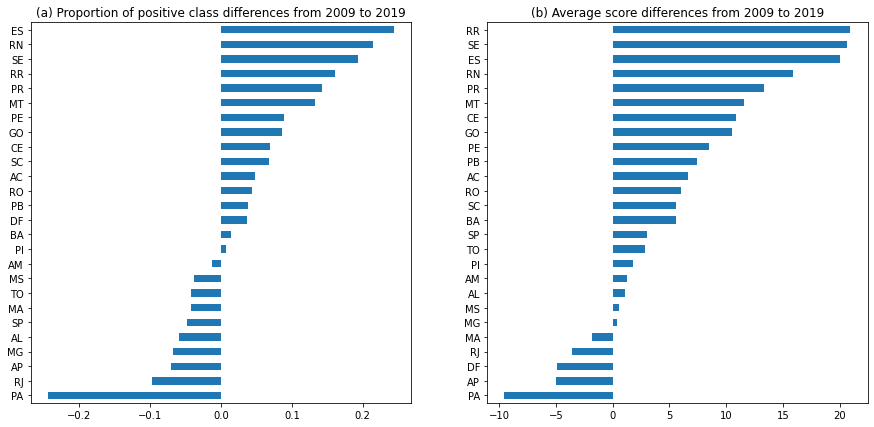

In [151]:
final2 = df_proportion_class(DATA, 'Municipal+Estadual', 'estado')[1]
fig, axes = plt.subplots(ncols=2, sharey=False)
ordered_final2 = final2.sort_values(by=2009)
ordered_final['diff'] = ordered_final[2019]- ordered_final[2009].sort_values()
ordered_final2['diff'] = ordered_final2[2019]- ordered_final2[2009].sort_values()


ordered_final.sort_values(by='diff')['diff'].plot.barh(figsize=(15,7), ax=axes[0])
ordered_final2.sort_values(by='diff')['diff'].plot.barh(figsize=(15,7), ax=axes[1])

axes[1].set_title('(b) Average score differences from 2009 to 2019')
axes[0].set_title('(a) Proportion of positive class differences from 2009 to 2019')
axes[0].set_ylabel('')
axes[1].set_ylabel('')

<AxesSubplot:>

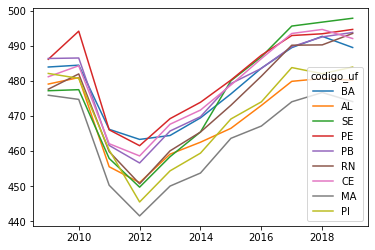

In [93]:
ordered_final2.loc[['BA','AL','SE','PE','PB','RN', 'CE','MA','PI']].drop(columns=['diff']).T.plot()


In [67]:
bar_plot = DATA
bar_plot['regiao_cnt'] = bar_plot[bar_plot.CO_ANO == 2019][['codigo_uf', 'regiao']].groupby('regiao').transform('count')
bar_plot['codigo_uf_cnt'] = bar_plot[bar_plot.CO_ANO == 2019][['codigo_uf', 'regiao']].groupby('codigo_uf').transform('count')


Text(0.5, 0.01, 'Number of schools')

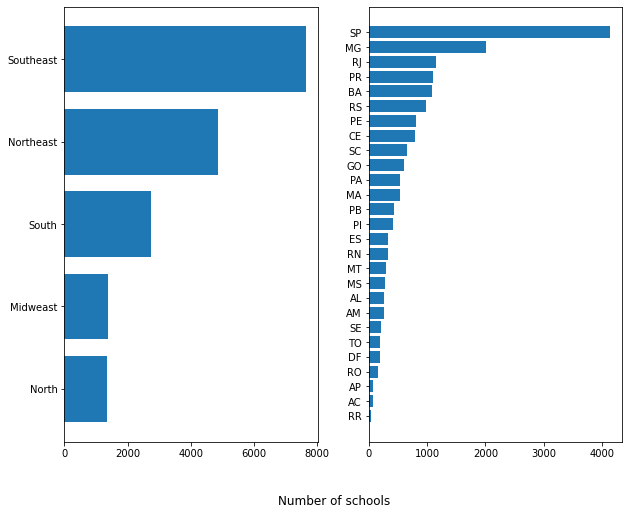

In [121]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 8))
#f = plt.figure(figsize=(7.1, 8))
bar_plot_1 = bar_plot[['regiao', 'regiao_cnt']].drop_duplicates('regiao').sort_values(by=['regiao_cnt'])
xlabels = ['North', 'Midweast', 'South', 'Northeast','Southeast']
ax1.barh(y = xlabels, width=bar_plot_1.regiao_cnt)
#ax1.xlabel('Number of schools')

bar_plot_2 = bar_plot[['codigo_uf', 'codigo_uf_cnt']].drop_duplicates('codigo_uf').sort_values(by=['codigo_uf_cnt'])
ax2.barh(y = bar_plot_2.codigo_uf, width=bar_plot_2.codigo_uf_cnt)
f.supxlabel('Number of schools')

In [44]:
with open('file1.pkl', 'rb') as f:
    regiao = pickle.load(f) 
with open('file2.pkl', 'rb') as f:
    states = pickle.load(f) 

In [45]:
states[2019]['']

KeyError: ''

In [46]:
states.items()

dict_items([(2009, {'FULL':    codigo_uf                   model    tp   tn   fp   fn        f1       acc  \
0         AC      AdaBoostClassifier     3   24    6    5  0.352941  0.710526   
1         AC      LogisticRegression     5   24    6    3  0.526316  0.763158   
2         AC  RandomForestClassifier     4   25    5    4  0.470588  0.763158   
3         AL      AdaBoostClassifier     5   81   13   13  0.277778  0.767857   
4         AL      LogisticRegression     3   88    6   15  0.222222  0.812500   
..       ...                     ...   ...  ...  ...  ...       ...       ...   
73        SP      LogisticRegression  1582  463  585  294  0.782587  0.699384   
74        SP  RandomForestClassifier  1792  162  886   84  0.787000  0.668263   
75        TO      AdaBoostClassifier    17   82   20   16  0.485714  0.733333   
76        TO      LogisticRegression    20   83   19   13  0.555556  0.762963   
77        TO  RandomForestClassifier    16   93    9   17  0.551724  0.807407   


In [47]:
DATA = DATA[DATA.IN_TP_ESCOLA=='Municipal+Estadual']

DATA['values'] = build_target(DATA)

df = DATA.groupby('codigo_uf')['values'].count().to_frame().reset_index()




Text(0.5, 0, 'quantity of schools')

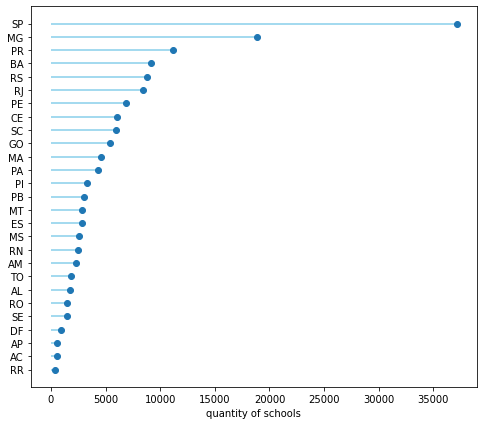

In [48]:
ordered_df = df.sort_values(by='values')
my_range=range(1,len(df.index)+1)
plt.figure(figsize=(8,7)) 
# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['values'], color='skyblue')
plt.plot(ordered_df['values'], my_range, "o")
 
# Add titles and axis names
plt.yticks(my_range, ordered_df['codigo_uf'])

plt.xlabel('quantity of schools')


In [92]:
DATA_2019 = DATA_2009.groupby('codigo_uf')['value1'].transform('mean')

In [136]:
ordered_df

,codigo_uf,values
21,RR,352
0,AC,567
3,AP,589
6,DF,887
24,SE,1453
20,RO,1494
1,AL,1754
26,TO,1872
2,AM,2281
19,RN,2508


In [179]:
classifiers = [LogisticRegression()]
models = {}
fairness = {}
for i in DATA1.CO_ANO.unique():
    models[i] = {}
    fairness[i] = {}
    for j in classifiers:
        name = type(j).__name__
        df = DATA1[DATA1.CO_ANO==i]
        models[i][name] = run_models_slice(df, 'regiao', independents, j)
        fairness[i][name] = compute_scores(models[i][name], 'regiao', 'Sudeste')